# MCMC for LMMs with a single vector-valued r.e. term

Creating a Stan model for linear mixed models (LMMs) with time-varying covariates in the random-effects terms requires a model matrix approach.

A simple example of a model with correlated random effects for slope and intercept is analyzed using both the [MixedModels package](https://github.com/dmbates/MixedModels.jl) and [Stan](http://mc-stan.org/) through the [Stan package](https://github.com/goedman/Stan.jl) for [Julia](http://julialang.org)

First we install the MixedModels package

In [1]:
Pkg.add("MixedModels")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of MixedModels
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [2]:
using DataFrames,Stan,Mamba,RDatasets,MixedModels

Environment variable JULIA_SVG_BROWSER not found.


In [3]:
const slp = dataset("lme4","sleepstudy")

,Reaction,Days,Subject
1,249.56,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


Start with a model for vector-valued random effects for a single grouping factor.  In the `MixedModels` package this would be fit as

In [4]:
m1 = fit(lmm(Reaction ~ 1 + Days + (1+Days|Subject), slp))

Linear mixed model fit by maximum likelihood
Formula: Reaction ~ 1 + Days + ((1 + Days) | Subject)

 logLik: -875.969672, deviance: 1751.939344

 Variance components:
                Variance    Std.Dev.  Corr.
 Subject      565.516376   23.780588
               32.682265    5.716840   0.08
 Residual     654.940901   25.591813
 Number of obs: 180; levels of grouping factors: 18

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   251.405   6.63228 37.9063
Days          10.4673   1.50224 6.96779


It is very fast to fit such a model

In [5]:
@time fit(lmm(Reaction ~ 1 + Days + (1+Days|Subject), slp));

elapsed time: 0.039349356 seconds (1785400 bytes allocated, 78.06% gc time)


## Creating a stan model

With some help from members of google group _stan-users_ I was able to create a stan formulation.  It is a bit tricky in that this model has random effects for time-varying covariates, `Days` in this case, and you need to form a dot product of the random-effects vector for the m'th `Subject` and a particular row of the random-effects model matrix.

In [Bates et al. (2014)](http://arxiv.org/abs/1406.5823) we describe how we use sparse matrices in the [lme4 package](https://github.com/lme4/lme4) for `R` to "expand" the evaluation of $Z\Lambda u$ across the random effects for each subject.  Matrices $Z$ and $\Lambda$ are both sparse in that formulation.

Here I create `Z` as an `array` of `row_vector`s.  `b` and `u` are arrays of column vectors.  This allows faster access to rows of `Z` and columns of `b` or `u`.


In [20]:
VectorOne = """
data {
  int<lower=0>  N; // num observations
  int<lower=1>  K; // length of fixed-effects vector
  int<lower=1>  M; // num subjects
  int<lower=1>  J; // length of individual vector-valued random effects
  int<lower=1,upper=M> subj[N]; // subject indicator
  matrix[N,K]   X; // model matrix for fixed-effects parameters
  row_vector[J] Z[N]; // generator model matrix for random-effects
  vector[N]     y; // response vector (reaction time)
}

parameters {
  cholesky_factor_corr[J] L; // Cholesky factor of unconditional correlation of random effects
  vector[J] tau;  // relative standard deviations of unconditional distribution of random effects
  vector[J] u[M]; // spherical random effects
  vector[K] beta; // fixed-effects
  real<lower=0> sigma; // standard deviation of response given random effects
}

transformed parameters {
  matrix[J,J] Lambda; 
  matrix[J,J] corr;
  vector[J] b[M];
  vector[N] muX;
  vector[N] mu;
  corr <- tcrossprod(L);  // for monitoring the correlations
  Lambda <- diag_pre_multiply(tau,L);
  for (m in 1:M)
    b[m] <-  Lambda * u[m];
  muX <- X * beta;
  for (n in 1:N)
    mu[n] <- muX[n] + Z[n] * b[subj[n]];
}

model {
  tau ~ cauchy(0,2.5);
  L ~ lkj_corr_cholesky(2);
  for (m in 1:M)
    u[m] ~ normal(0,sigma);
  y ~ normal(mu, sigma);
}
""";

In [7]:
const Xt = vcat(ones(Float64,(1,180)),array(slp[:Days])')

2x180 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0     3.0  4.0  5.0  6.0  7.0  8.0  9.0

In [8]:
const sleepdata = [
    @Compat.Dict("N" => size(slp,1),
    "K" => 2,
    "M" => 18,
    "J" => 2,
    "subj" => slp[:Subject].refs,
    "y" => array(slp[:Reaction]),
    "X" => Xt',
    "Z" => Xt')
]

1-element Array{Dict{ASCIIString,Any},1}:
 ["Z"=>180x2 Array{Float64,2}:
 1.0  0.0
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
 1.0  6.0
 1.0  7.0
 1.0  8.0
 1.0  9.0
 1.0  0.0
 1.0  1.0
 1.0  2.0
 ⋮       
 1.0  8.0
 1.0  9.0
 1.0  0.0
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
 1.0  6.0
 1.0  7.0
 1.0  8.0
 1.0  9.0,"J"=>2,"M"=>18,"X"=>180x2 Array{Float64,2}:
 1.0  0.0
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
 1.0  6.0
 1.0  7.0
 1.0  8.0
 1.0  9.0
 1.0  0.0
 1.0  1.0
 1.0  2.0
 ⋮       
 1.0  8.0
 1.0  9.0
 1.0  0.0
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
 1.0  6.0
 1.0  7.0
 1.0  8.0
 1.0  9.0,"N"=>180,"subj"=>Uint8[0x01,0x01,0x01,0x01,0x01,0x01,0x01,0x01,0x01,0x01  …  0x12,0x12,0x12,0x12,0x12,0x12,0x12,0x12,0x12,0x12],"K"=>2,"y"=>[249.56,258.705,250.801,321.44,356.852,414.69,382.204,290.149,430.585,466.353  …  269.412,273.474,297.597,310.632,287.173,329.608,334.482,343.22,369.142,364.124]]

In [9]:
stanmodel = Stanmodel(name="VectorOne", model=VectorOne);


File /home/juser/notebooks/tmp/VectorOne.stan will be updated.



In [10]:
sim1 = stan(stanmodel, sleepdata)



--- Translating Stan model to C++ code ---
bin/stanc /home/juser/notebooks/tmp/VectorOne.stan --o=/home/juser/notebooks/tmp/VectorOne.cpp --no_main
Model name=VectorOne_model
Input file=/home/juser/notebooks/tmp/VectorOne.stan
Output file=/home/juser/notebooks/tmp/VectorOne.cpp

--- Linking C++ model ---
g++ -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I src -I stan/src -isystem stan/lib/eigen_3.2.0 -isystem stan/lib/boost_1.54.0 -Wall -pipe -DEIGEN_NO_DEBUG -Wno-unused-local-typedefs  -lpthread  -O3 -o /home/juser/notebooks/tmp/VectorOne src/cmdstan/main.cpp -include /home/juser/notebooks/tmp/VectorOne.cpp -Lbin -lstan

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Inference for Stan model: VectorOne_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (8.8, 7.3, 8.5, 9.3) seconds, 34 seconds total
Sampling took (2.1, 2.2, 2.0, 2.0) seconds

Object of type "Chains"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

1000x451x4 Array{Float64,3}:
[:, :, 1] =
 -793.31   0.992811  0.124415  5.0  …  342.061  356.743  371.426  386.108
 -794.997  0.865766  0.124415  5.0     339.342  349.479  359.616  369.752
 -800.168  0.853928  0.124415  5.0     345.155  362.283  379.41   396.538
 -796.683  0.596045  0.124415  5.0     340.022  354.281  368.54   382.798
 -796.762  0.924517  0.124415  5.0     339.466  353.755  368.044  382.332
 -799.264  0.867413  0.124415  5.0  …  327.458  339.602  351.747  363.891
 -812.63   0.646409  0.124415  5.0     331.569  337.818  344.066  350.314
 -809.704  0.753654  0.124415  5.0     337.041  349.644  362.247  374.849
 -804.193  0.912558  0.124415  5.0     332.523  341.089  349.654  358.22 
 -812.59   1.0       0.124415  5.0     329.03   341.584  354.137  366.69 
 -807.413  0.999822  0.124415  5.0  …  344.503  358.774  373.045  387.316
 -804.943  0.904351  0.124415  5.0 

In [11]:
sim1.names

451-element Array{String,1}:
 "lp__"         
 "accept_stat__"
 "stepsize__"   
 "treedepth__"  
 "n_leapfrog__" 
 "n_divergent__"
 "L.1.1"        
 "L.2.1"        
 "L.1.2"        
 "L.2.2"        
 "tau.1"        
 "tau.2"        
 "u.1.1"        
 ⋮              
 "mu.169"       
 "mu.170"       
 "mu.171"       
 "mu.172"       
 "mu.173"       
 "mu.174"       
 "mu.175"       
 "mu.176"       
 "mu.177"       
 "mu.178"       
 "mu.179"       
 "mu.180"       

In practice it would not make sense to monitor all the parameters and transformed parameters.  We avoid doing so by creating a vector of names to monitor.

In [30]:
monitor = ["lp__", "accept_stat__","corr.2.1","tau","sigma","beta.1","beta.2"]

7-element Array{ASCIIString,1}:
 "lp__"         
 "accept_stat__"
 "corr.2.1"     
 "tau"          
 "sigma"        
 "beta.1"       
 "beta.2"       

In [31]:
stanmodel = Stanmodel(name="VectorOne", model=VectorOne, monitors=monitor);

In [32]:
sim1 = stan(stanmodel,sleepdata)


make: `/home/juser/notebooks/tmp/VectorOne' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Inference for Stan model: VectorOne_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (8.5, 8.6, 8.7, 8.3) seconds, 34 seconds total
Sampling took (2.3, 2.1, 2.4, 2.1) seconds, 8.9 seconds total

                    Mean     MCSE   StdDev     5%       50%    95%  N_Eff  N_Eff/s    R_hat
lp__            -8.1e+02  3.1e-01  7.1e+00   -818  -8.1e+02   -795    513       58  1.0e+00
accept_stat__    9.0e-01  3.8e-03  1.1e-01   0.68   9.4e-01   1.00    814       92  1.0e+00
stepsize__       1.2e-01  5.3e-03  7.5e-03   0.11   1.3e-01   0.13    2.0     0.23  3.6e+13
treedepth__      5.1e+00  4.0e-02  4.7e-01    5.0   5.0e+00    6.0    140       16  1.0e+00
n_leapfrog__     3.6e+01  1.1e+00  1.3e+01     31   3.1e+01     63    136       15  1.0e+00
n_divergent__    0.0e+0

Object of type "Chains"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

1000x6x4 Array{Float64,3}:
[:, :, 1] =
 -815.697  0.985006  264.334  10.8624   28.3299   0.0822864  
 -808.643  0.922693  251.066  13.9612   24.3132  -0.211258   
 -810.434  0.990091  261.887  12.4895   27.5112  -0.222108   
 -803.304  0.872016  253.585  11.2558   27.8068  -0.448574   
 -804.147  0.996153  253.869  10.6713   27.0106  -0.00599786 
 -806.245  0.981729  245.052  11.8945   24.1979   0.431815   
 -801.223  0.988624  251.392  11.3623   26.7576   0.299557   
 -798.971  0.744038  250.373  10.6076   25.4136   0.588023   
 -808.597  0.775222  256.122  10.287    23.992    0.416816   
 -810.447  0.794945  247.313  10.2401   28.9321   0.109694   
 -797.505  0.998362  254.546   7.82196  23.3599  -0.0671751  
 -804.454  0.90528   256.927   7.19276  26.964   -0.343736   
 -804.502  0.946078  255.767  10.9682   23.6349  -0.107714   
    ⋮                                        

In [33]:
describe(sim1)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
7x6 Array{Any,2}:
 ""                   "Mean"     "SD"      "Naive SE"   "MCSE"         "ESS"
 "lp__"           -805.682      7.05735   0.111587     0.301594    1479.95  
 "accept_stat__"     0.904107   0.109303  0.00172823   0.00211367  3270.57  
 "beta.1"          251.53       7.30108   0.11544      0.146232    3157.74  
 "beta.2"           10.354      1.67447   0.0264758    0.0476424   2222.88  
 "sigma"            25.7123     1.48082   0.0234138    0.0424757   2204.91  
 "corr.2.1"          0.0238965  0.277309  0.00438464   0.00823153  2130.65  

Quantiles:
7x6 Array{Any,2}:
 ""                   "2.5%"       "25.0%"  …      "75.0%"      "97.5%"
 "lp__"           -820.796     -810.176        -800.917     -792.868   
 "accept_stat__"     0.605716     0.868183        0.981413     0.999849
 "beta.1"          237.576      246.745         256.072      266.295   
 "beta.2"

In [35]:
p = plot(sim1,[:trace,:density]);

 in traceplot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:26
 in plot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:13
 in plot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:7
 in include_string at loading.jl:97
 in execute_request_0x535c5df2 at /home/juser/.julia/v0.3/IJulia/src/execute_request.jl:160
 in eventloop at /home/juser/.julia/v0.3/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:340
 in traceplot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:26
 in plot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:13
 in plot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:7
 in include_string at loading.jl:97
 in execute_request_0x535c5df2 at /home/juser/.julia/v0.3/IJulia/src/execute_request.jl:160
 in eventloop at /home/juser/.julia/v0.3/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:340
 in traceplot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:26
 in plot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:13
 in plot at /home/juser/.juli

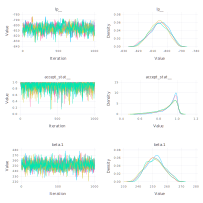

Press ENTER to draw next plot
STDIN> 


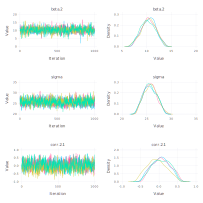

In [36]:
draw(p)